In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


ticker = "^NDX"
end_date = datetime.now()
start_date = end_date - timedelta(days=365*5)

data = yf.download(ticker, start=start_date, end=end_date)
data.to_csv('it_stock_index.csv')
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker             ^NDX         ^NDX         ^NDX         ^NDX        ^NDX
Date                                                                      
2020-04-13  8332.740234  8338.150391  8158.580078  8209.679688  3184660000
2020-04-14  8692.160156  8708.549805  8470.740234  8489.269531  3767410000
2020-04-15  8591.959961  8666.240234  8500.559570  8548.469727  3347920000
2020-04-16  8757.830078  8793.349609  8605.509766  8689.089844  4057800000
2020-04-17  8832.410156  8879.240234  8704.379883  8876.660156  4348310000


In [ ]:

df = data.copy()


df['Daily_Return'] = df['Close'].pct_change()


df['Next_Close'] = df['Close'].shift(-1)


df['SMA_5'] = df['Close'].rolling(window=5).mean()  e
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['Price_Change'] = df['Close'].diff()
df['Volume_Change'] = df['Volume'].pct_change()


df = df.dropna()

print(df.head())

Price             Close         High          Low         Open      Volume  \
Ticker             ^NDX         ^NDX         ^NDX         ^NDX        ^NDX   
Date                                                                         
2020-04-24  8786.599609  8791.360352  8599.990234  8666.570312  3696020000   
2020-04-27  8837.660156  8887.620117  8803.889648  8865.580078  3694980000   
2020-04-28  8677.599609  8918.379883  8668.669922  8913.280273  3730350000   
2020-04-29  8982.759766  9025.820312  8832.000000  8871.040039  4407140000   
2020-04-30  9000.509766  9023.030273  8920.419922  9005.240234  4335660000   

Price      Daily_Return   Next_Close        SMA_5       SMA_10        EMA_5  \
Ticker                                                                        
Date                                                                          
2020-04-24     0.016791  8837.660156  8644.449805  8642.934961  8678.781691   
2020-04-27     0.005811  8677.599609  8666.679883  8693.426

In [ ]:
from sklearn.model_selection import train_test_split

features = ['Close', 'SMA_5', 'SMA_10', 'EMA_5', 'Price_Change', 'Volume_Change', 'Volume']
X = df[features]
y = df['Next_Close']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 997
Testing set size: 250


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
model.fit(X_train, y_train)


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")


coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

Training RMSE: 192.77
Testing RMSE: 298.97
Training R²: 0.99
Testing R²: 0.94
         Feature   Coefficient
0          Close  1.047146e+00
1          SMA_5  1.555908e-01
2         SMA_10  7.038814e-02
3          EMA_5 -2.775468e-01
4   Price_Change -4.150503e-02
5  Volume_Change -8.049948e+01
6         Volume  6.434211e-09


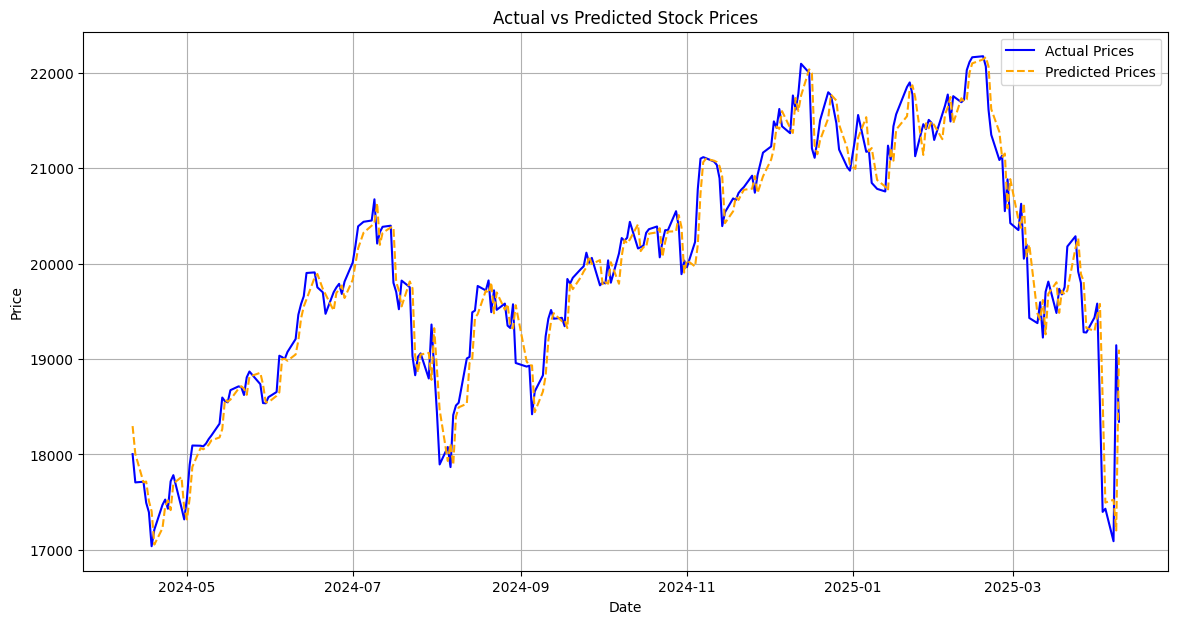

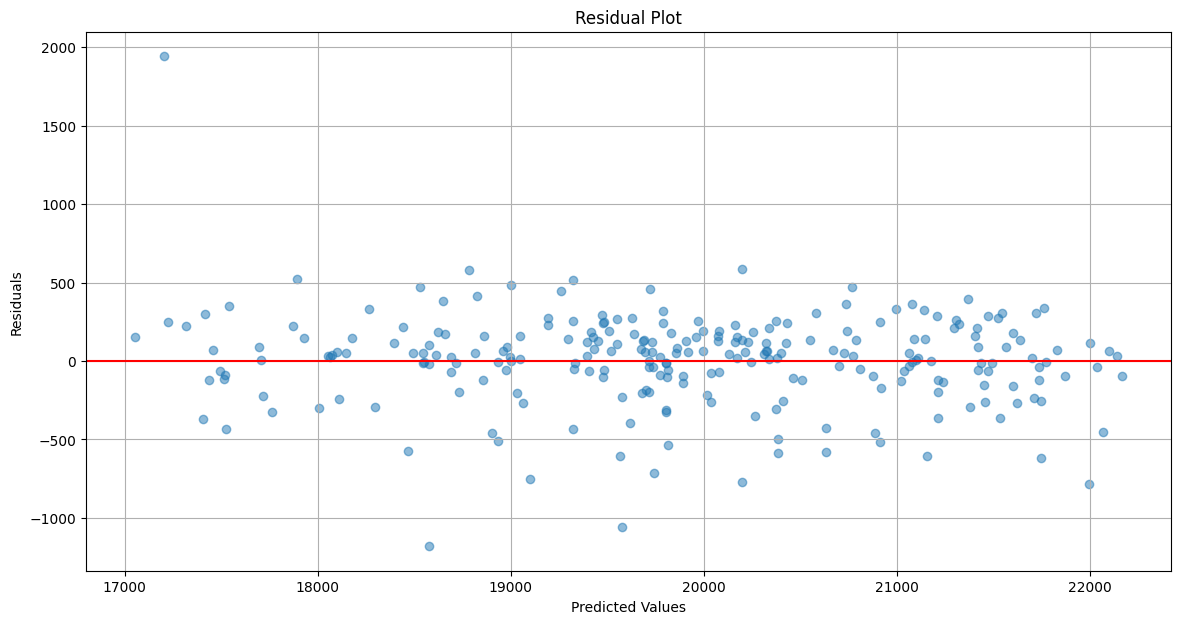

In [ ]:
import matplotlib.pyplot as plt


results = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred}, index=y_test.index)


plt.figure(figsize=(14, 7))
plt.plot(results['Actual'], label='Actual Prices', color='blue')
plt.plot(results['Predicted'], label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


residuals = y_test - test_pred
plt.figure(figsize=(14, 7))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [ ]:

def predict_next_day(current_data, model):
    """
    current_data: DataFrame with the latest available data (must contain all features)
    model: trained regression model
    """

    features = current_data[['Close', 'SMA_5', 'SMA_10', 'EMA_5', 'Price_Change', 'Volume_Change', 'Volume']]
    return model.predict(features)


latest_data = df.iloc[-1:].copy()
predicted_price = predict_next_day(latest_data, model)
print(f"Latest Close Price: {float(latest_data['Close'].values[0]):.2f}")
print(f"Predicted Next Close Price: {predicted_price[0]:.2f}")

Latest Close Price: 19145.06
Predicted Next Close Price: 19098.46


<ipython-input-8-2fcc38c14903>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Latest Close Price: {float(latest_data['Close'].values[0]):.2f}")


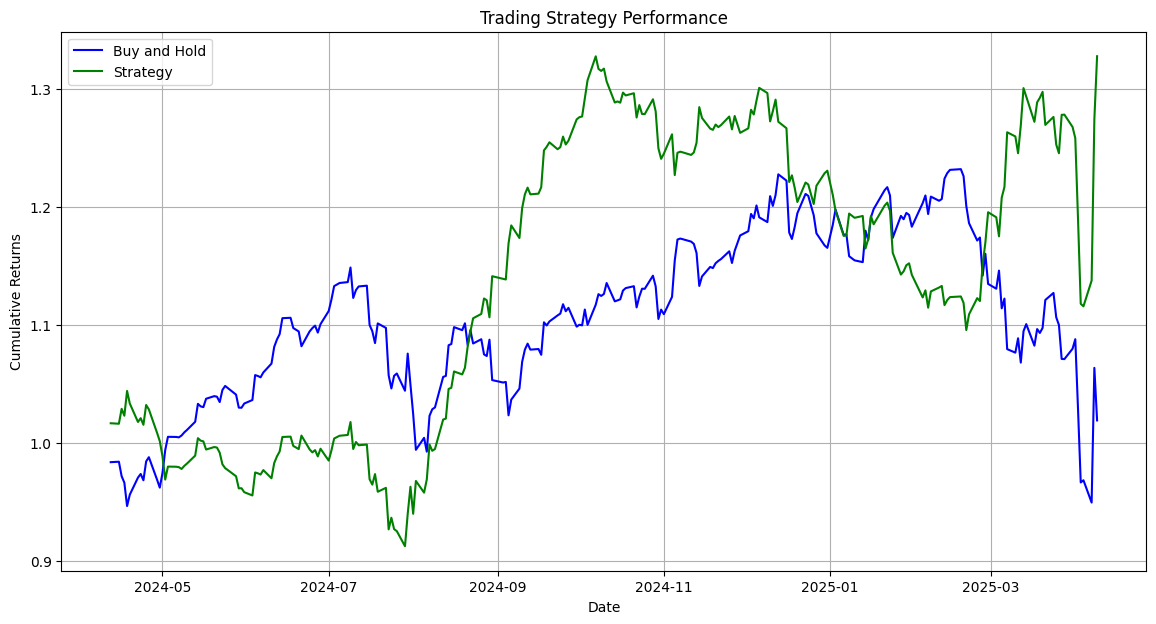

In [ ]:

results = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred}, index=y_test.index)
results['Predicted_Return'] = results['Predicted'].pct_change()
results['Position'] = np.where(results['Predicted_Return'] > 0, 1, -1)  # 1 for long, -1 for short
results['Strategy_Return'] = results['Position'].shift(1) * results['Actual'].pct_change()


results['Cumulative_Market'] = (1 + results['Actual'].pct_change()).cumprod()
results['Cumulative_Strategy'] = (1 + results['Strategy_Return']).cumprod()


plt.figure(figsize=(14, 7))
plt.plot(results['Cumulative_Market'], label='Buy and Hold', color='blue')
plt.plot(results['Cumulative_Strategy'], label='Strategy', color='green')
plt.title('Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()